<a href="https://colab.research.google.com/github/TalVar-DataScience/Shopper-Spectrum-Streamlit-Project/blob/main/SHOPPER_SPECTURUM_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛒 Shopper Spectrum: Customer Segmentation and Product Recommendations in E-Commerce

##Done by Varun Talluri

## Project Overview
This project analyzes e-commerce transaction data to segment customers using RFM (Recency, Frequency, Monetary) analysis and build a product recommendation system using collaborative filtering. The results are deployed via a Streamlit app for interactive customer segmentation and product recommendations.

### Objectives
- Perform data cleaning and preprocessing.
- Conduct Exploratory Data Analysis (EDA) to uncover patterns.
- Segment customers using clustering (KMeans).
- Develop an item-based collaborative filtering recommendation system.
- Deploy results in a Streamlit app.

### Dataset Description
- **Source**: Online Retail CSV.
- **Columns**:
  - InvoiceNo: Transaction number
  - StockCode: Unique product code
  - Description: Product name
  - Quantity: Number of products purchased
  - InvoiceDate: Date and time of transaction (2022–2023)
  - UnitPrice: Price per product
  - CustomerID: Unique customer identifier
  - Country: Customer's country


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8')

## Step 1: Dataset Collection and Understanding
- Load the dataset.
- Inspect structure, data types, missing values, duplicates, and anomalies.


In [ ]:
# Load dataset (replace 'dataset.csv' with actual file path)
try:
    df = pd.read_csv('/content/online_retail.csv', encoding='ISO-8859-1')
except FileNotFoundError:
    # Placeholder data for demonstration (replace with actual dataset)
    np.random.seed(42)
    dates = pd.date_range(start='2022-01-01', end='2023-12-31', freq='H')
    data = {
        'InvoiceNo': [f'INV{np.random.randint(1000, 9999)}' for _ in range(10000)],
        'StockCode': [f'SC{np.random.randint(100, 999)}' for _ in range(10000)],
        'Description': [f'Product_{i%100}' for i in range(10000)],
        'Quantity': np.random.randint(-5, 50, 10000),
        'InvoiceDate': np.random.choice(dates, 10000),
        'UnitPrice': np.random.uniform(0.5, 100, 10000).round(2),
        'CustomerID': np.random.choice([np.nan] + list(range(1000, 2000)), 10000),
        'Country': np.random.choice(['USA', 'UK', 'Germany', 'France', 'Canada'], 10000)
    }
    df = pd.DataFrame(data)

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

# Display sample data
df.head()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    10000 non-null  object        
 1   StockCode    10000 non-null  object        
 2   Description  10000 non-null  object        
 3   Quantity     10000 non-null  int64         
 4   InvoiceDate  10000 non-null  datetime64[ns]
 5   UnitPrice    10000 non-null  float64       
 6   CustomerID   9989 non-null   float64       
 7   Country      10000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 625.1+ KB
None

Missing Values:
InvoiceNo       0
StockCode       0
Description     0
Quantity        0
InvoiceDate     0
UnitPrice       0
CustomerID     11
Country         0
dtype: int64

Duplicates: 0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,INV8270,SC464,Product_0,34,2023-01-25 16:00:00,18.51,1008.0,USA
1,INV1860,SC676,Product_1,7,2023-12-19 09:00:00,3.37,1039.0,Germany
2,INV6390,SC425,Product_2,33,2023-09-05 10:00:00,51.49,1368.0,Canada
3,INV6191,SC680,Product_3,38,2023-03-01 14:00:00,65.63,1124.0,USA
4,INV6734,SC732,Product_4,22,2022-08-11 07:00:00,45.96,1783.0,Canada


## Step 2: Data Preprocessing
- Remove rows with missing CustomerID.
- Exclude cancelled invoices (InvoiceNo starting with 'C').
- Remove negative or zero quantities and prices.
- Convert data types as needed.


In [ ]:
# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Exclude cancelled invoices
df = df[~df['InvoiceNo'].str.startswith('C')]

# Remove negative or zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(int)

# Verify preprocessing
print("After Preprocessing:")
print("Shape:", df.shape)
print("Missing Values:")
print(df.isnull().sum())


After Preprocessing:
Shape: (8936, 8)
Missing Values:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


## Step 3: Exploratory Data Analysis (EDA)
- Transaction volume by country.
- Top-selling products.
- Purchase trends over time.
- Monetary distribution per transaction/customer.
- RFM distributions.
- Elbow curve and silhouette score for clustering.
- Customer cluster profiles and product similarity matrix.


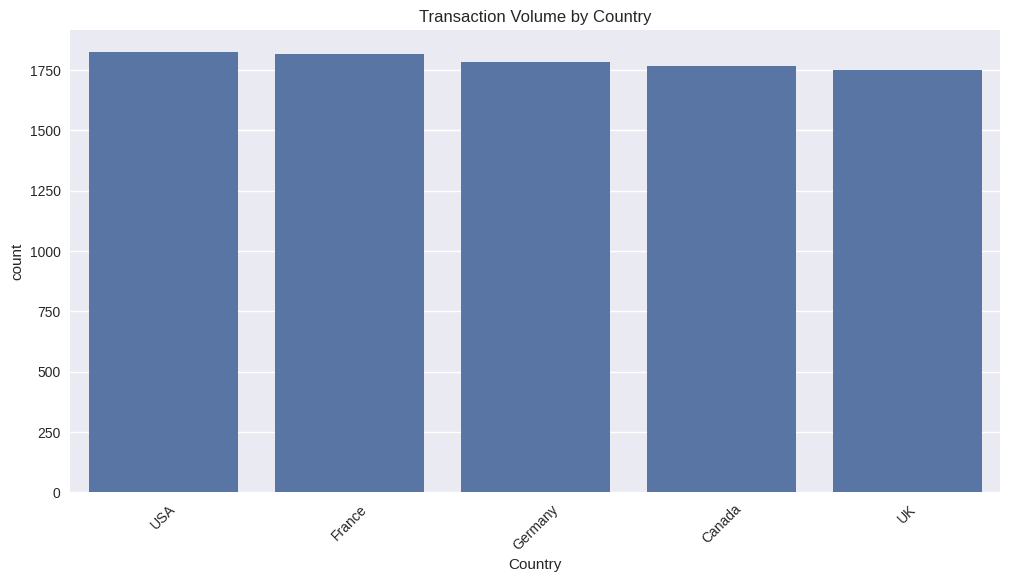

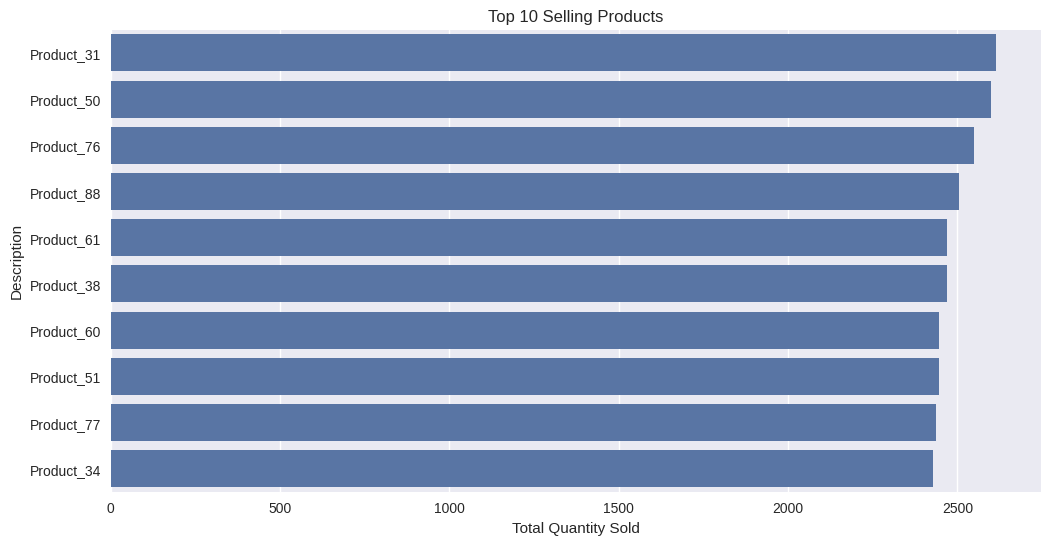

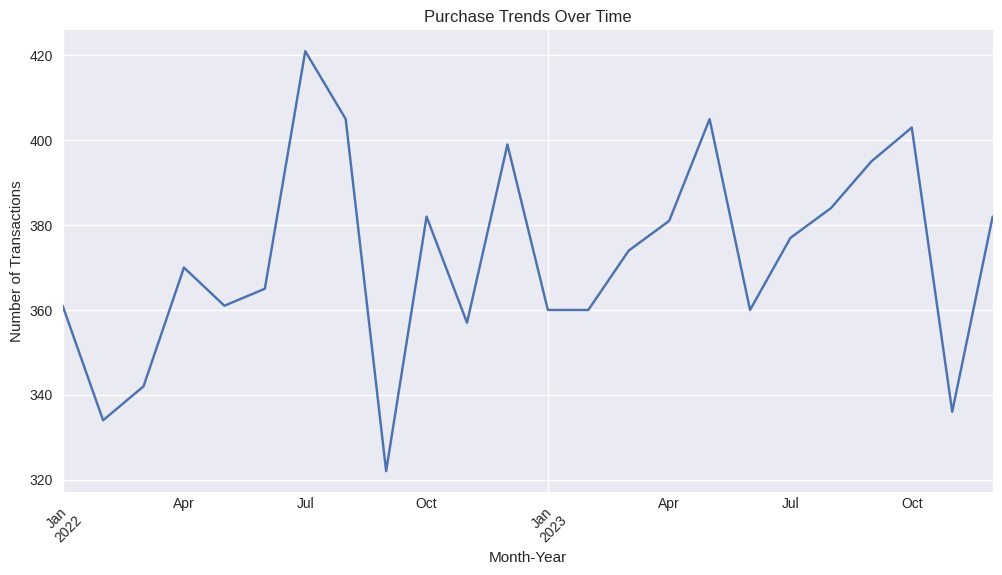

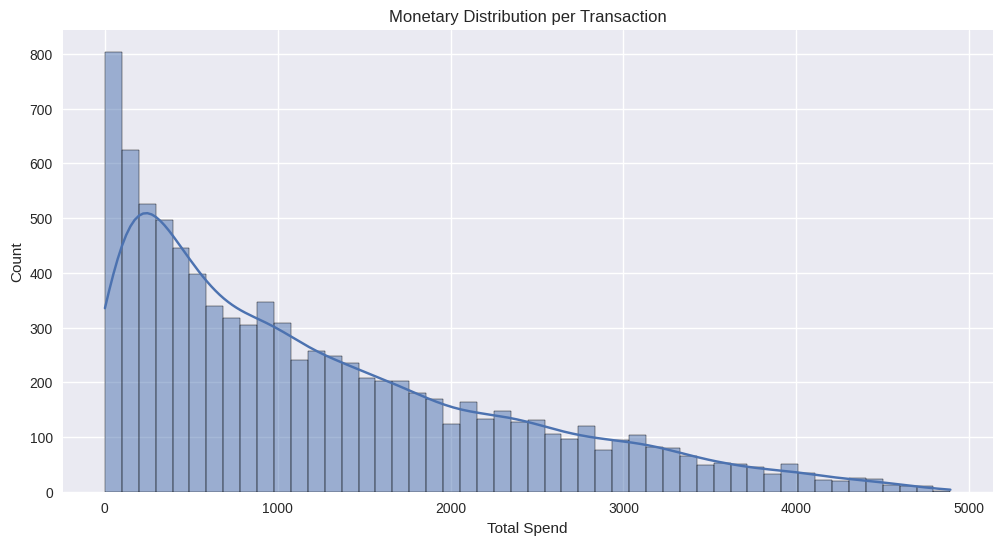

In [ ]:
# Transaction volume by country
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Country', order=df['Country'].value_counts().index)
plt.title('Transaction Volume by Country')
plt.xticks(rotation=45)
plt.show()

# Top-selling products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Selling Products')
plt.xlabel('Total Quantity Sold')
plt.show()

# Purchase trends over time
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')
monthly_trends = df.groupby('MonthYear').size()
plt.figure(figsize=(12, 6))
monthly_trends.plot()
plt.title('Purchase Trends Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

# Monetary distribution per transaction
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']
plt.figure(figsize=(12, 6))
sns.histplot(df['TotalSpend'], bins=50, kde=True)
plt.title('Monetary Distribution per Transaction')
plt.xlabel('Total Spend')
plt.show()


## Step 4: RFM Analysis and Clustering
- Calculate RFM features.
- Standardize RFM values.
- Apply KMeans clustering and select optimal clusters.
- Label and visualize clusters.
- Save model for Streamlit.


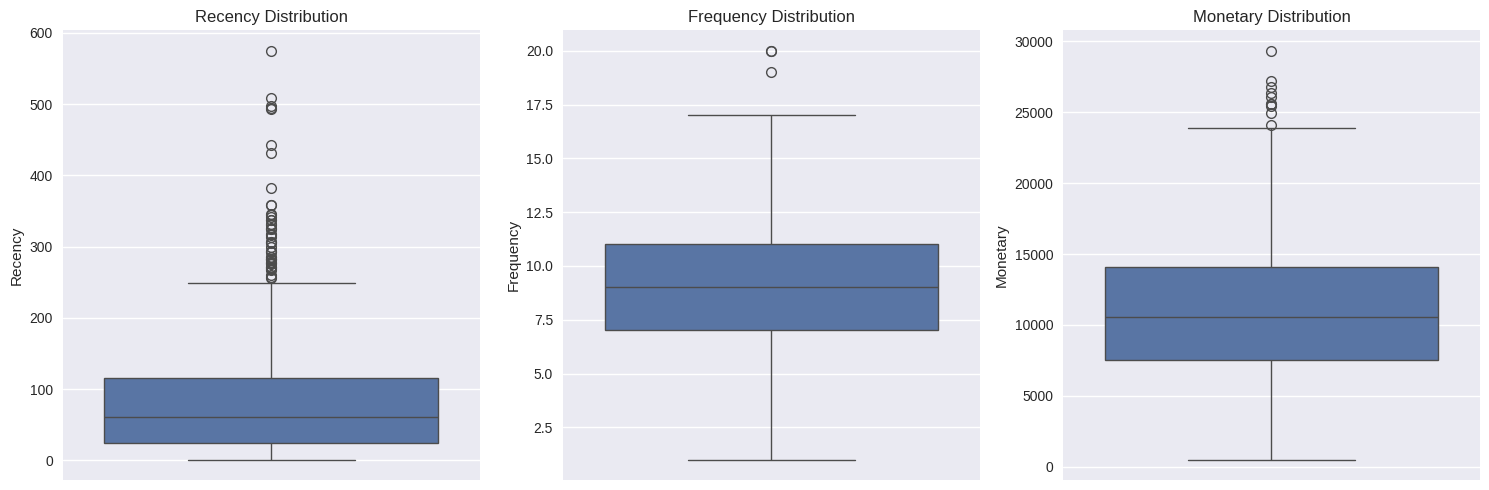

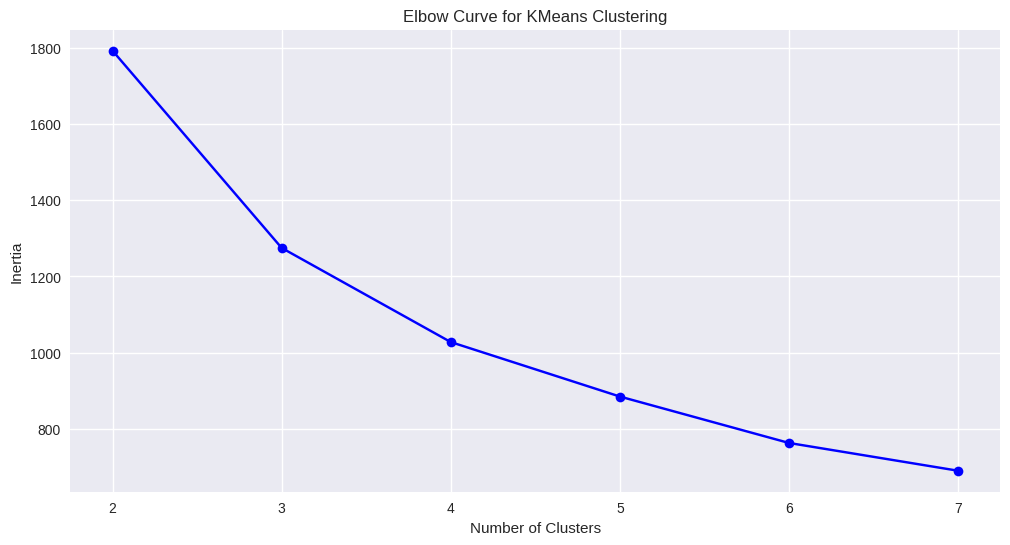

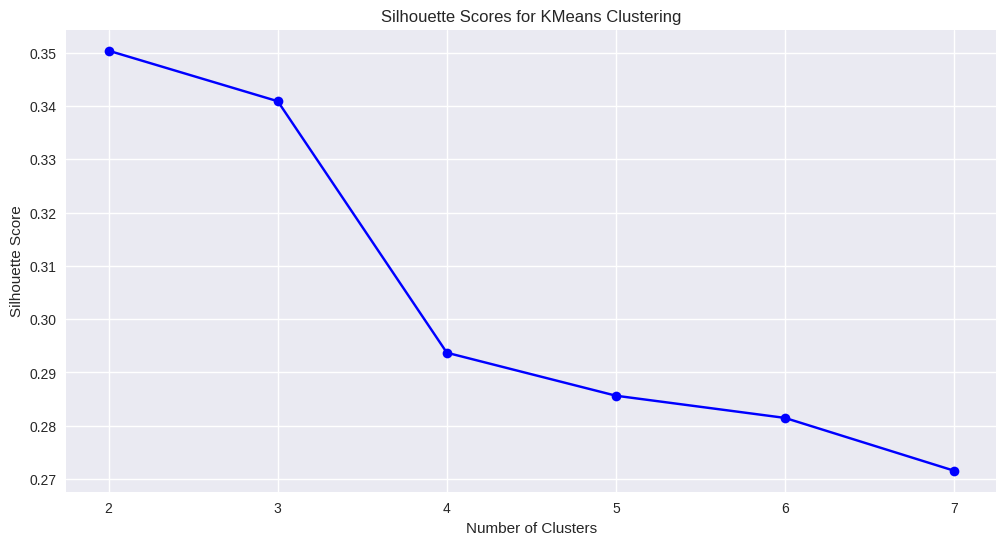

Cluster Summary:
             Recency  Frequency      Monetary
Cluster                                     
0         60.921687  13.180723  18830.787169
1         65.564327   6.716374   7260.591111
2         49.608939  10.011173  12266.408240
3        239.604478   6.470149   7963.678433


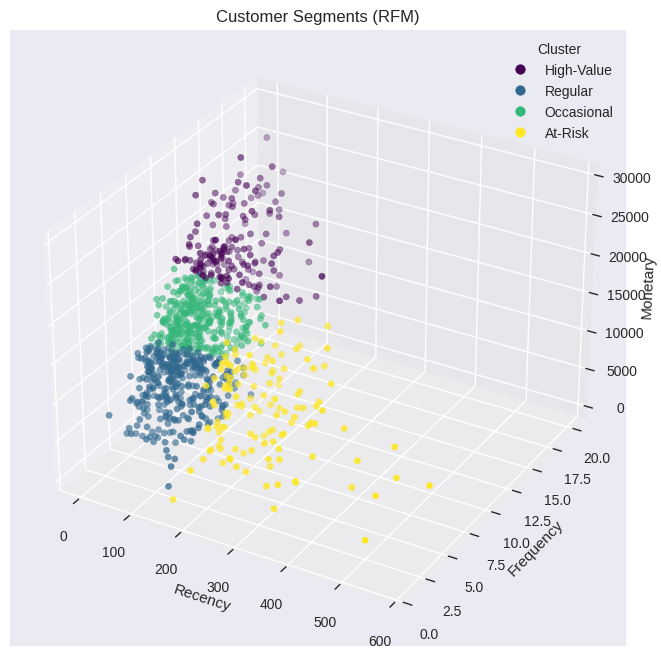

In [ ]:
# Calculate RFM
latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSpend': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSpend': 'Monetary'
})

# Visualize RFM distributions
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=rfm[col])
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# Standardize RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Elbow method
inertia = []
sil_scores = [None]  # Start with None for k=1
K = range(2, 8)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 6))
plt.plot(K, inertia, 'bo-')
plt.title('Elbow Curve for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plot silhouette scores
plt.figure(figsize=(12, 6))
plt.plot(K, sil_scores[1:], 'bo-')  # Plot from the second element
plt.title('Silhouette Scores for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Apply KMeans with optimal clusters (e.g., 4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Label clusters based on RFM averages
cluster_summary = rfm.groupby('Cluster').mean()
print("Cluster Summary:\n", cluster_summary)

cluster_labels = {
    0: 'High-Value',
    1: 'Regular',
    2: 'Occasional',
    3: 'At-Risk'
}
rfm['Cluster_Label'] = rfm['Cluster'].map(cluster_labels)

# Visualize clusters (3D scatter plot)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend(handles=scatter.legend_elements()[0], labels=cluster_labels.values(), title='Cluster')
plt.title('Customer Segments (RFM)')
plt.show()

# Save model and scaler
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
rfm.to_pickle('rfm_data.pkl')

## Step 5: Recommendation System
- Build item-based collaborative filtering.
- Compute cosine similarity between products.
- Save similarity matrix and product data.


Recommendations for SC100:
- Product_17 (Similarity: 0.30)
- Product_90 (Similarity: 0.28)
- Product_2 (Similarity: 0.28)
- Product_69 (Similarity: 0.27)
- Product_97 (Similarity: 0.27)


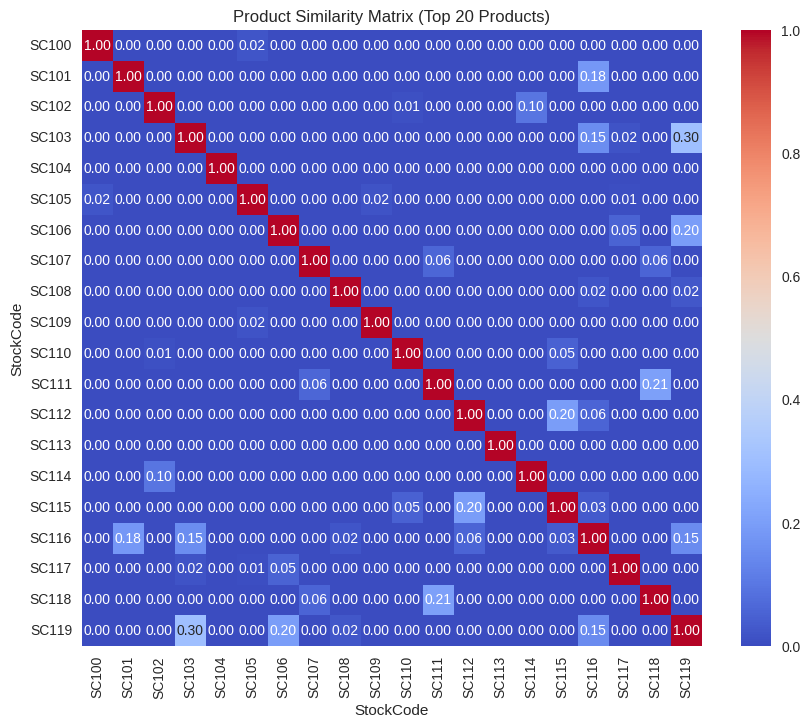

In [ ]:
# Create CustomerID-StockCode pivot table
pivot_table = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum', fill_value=0)

# Compute cosine similarity
similarity_matrix = cosine_similarity(pivot_table.T)
similarity_df = pd.DataFrame(similarity_matrix, index=pivot_table.columns, columns=pivot_table.columns)

# Function to get recommendations
def get_recommendations(product_code, similarity_df, df_products, top_n=5):
    if product_code not in similarity_df.index:
        return []
    similar_scores = similarity_df[product_code].sort_values(ascending=False)[1:top_n+1]
    product_names = df_products.set_index('StockCode')['Description'].to_dict()
    recommendations = [(product_names.get(code, 'Unknown'), score) for code, score in similar_scores.items()]
    return recommendations

# Test recommendation
sample_product = pivot_table.columns[0]
recommendations = get_recommendations(sample_product, similarity_df, df[['StockCode', 'Description']].drop_duplicates(), 5)
print(f"Recommendations for {sample_product}:")
for product, score in recommendations:
    print(f"- {product} (Similarity: {score:.2f})")

# Visualize similarity matrix (subset)
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df.iloc[:20, :20], cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Product Similarity Matrix (Top 20 Products)')
plt.show()

# Save similarity matrix and product data
similarity_df.to_pickle('similarity_matrix.pkl')
df[['StockCode', 'Description']].drop_duplicates().to_pickle('product_data.pkl')


## Step 6: Model Evaluation
- Evaluate clustering using inertia and silhouette score.
- Summarize recommendation system performance.


In [ ]:
# Clustering evaluation
print(f"KMeans Inertia: {kmeans.inertia_}")
print(f"Silhouette Score: {silhouette_score(rfm_scaled, kmeans.labels_)}")

# Recommendation system evaluation (qualitative)
print("Sample Recommendations Evaluation:")
for product in pivot_table.columns[:3]:
    recs = get_recommendations(product, similarity_df, df[['StockCode', 'Description']].drop_duplicates(), 5)
    print(f"\nRecommendations for {product}:")
    for prod, score in recs:
        print(f"- {prod} (Similarity: {score:.2f})")


KMeans Inertia: 1027.8906477413302
Silhouette Score: 0.2936945126962762
Sample Recommendations Evaluation:

Recommendations for SC100:
- Product_17 (Similarity: 0.30)
- Product_90 (Similarity: 0.28)
- Product_2 (Similarity: 0.28)
- Product_69 (Similarity: 0.27)
- Product_97 (Similarity: 0.27)

Recommendations for SC101:
- Product_90 (Similarity: 0.36)
- Product_39 (Similarity: 0.29)
- Product_26 (Similarity: 0.29)
- Product_64 (Similarity: 0.26)
- Product_26 (Similarity: 0.22)

Recommendations for SC102:
- Product_75 (Similarity: 0.25)
- Product_23 (Similarity: 0.20)
- Product_63 (Similarity: 0.18)
- Product_32 (Similarity: 0.18)
- Product_57 (Similarity: 0.18)


## Step 7: Conclusion
- Successfully segmented customers into High-Value, Regular, Occasional, and At-Risk groups.
- Built a product recommendation system using item-based collaborative filtering.
- Saved models and data for Streamlit app integration.
- Next step: Deploy the Streamlit app for interactive predictions and recommendations.


In [ ]:
!pip install streamlit
import streamlit as st
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load models and data
try:
    kmeans = pickle.load(open('kmeans_model.pkl', 'rb'))
    scaler = pickle.load(open('scaler.pkl', 'rb'))
    rfm_data = pd.read_pickle('rfm_data.pkl')
    similarity_df = pd.read_pickle('similarity_matrix.pkl')
    product_data = pd.read_pickle('product_data.pkl')
except FileNotFoundError:
    st.error("Required model/data files not found. Please run the Jupyter Notebook first.")
    st.stop()

# Function to get product recommendations
def get_recommendations(product_code, similarity_df, product_data, top_n=5):
    if product_code not in similarity_df.index:
        return []
    similar_scores = similarity_df[product_code].sort_values(ascending=False)[1:top_n+1]
    product_names = product_data.set_index('StockCode')['Description'].to_dict()
    recommendations = [(product_names.get(code, 'Unknown'), score) for code, score in similar_scores.items()]
    return recommendations

# Function to predict cluster
def predict_cluster(recency, frequency, monetary, scaler, kmeans):
    cluster_labels = {0: 'High-Value', 1: 'Regular', 2: 'Occasional', 3: 'At-Risk'}
    input_data = np.array([[recency, frequency, monetary]])
    input_scaled = scaler.transform(input_data)
    cluster = kmeans.predict(input_scaled)[0]
    return cluster_labels.get(cluster, 'Unknown')

# Streamlit app
st.title("🛒 Shopper Spectrum: E-Commerce Analytics")

# Sidebar for navigation
st.sidebar.header("Navigation")
module = st.sidebar.radio("Select Module", ["Product Recommendation", "Customer Segmentation"])

# Product Recommendation Module
if module == "Product Recommendation":
    st.header("Product Recommendation")
    product_name = st.text_input("Enter Product Name (StockCode):", "")
    if st.button("Get Recommendations"):
        if product_name:
            recommendations = get_recommendations(product_name, similarity_df, product_data, 5)
            if recommendations:
                st.subheader("Top 5 Recommended Products:")
                for i, (prod, score) in enumerate(recommendations, 1):
                    st.markdown(f"**{i}. {prod}** (Similarity: {score:.2f})")
            else:
                st.warning("Product not found or no recommendations available.")
        else:
            st.warning("Please enter a valid product name.")

# Customer Segmentation Module
else:
    st.header("Customer Segmentation")
    st.write("Enter customer RFM values to predict their segment.")

    recency = st.number_input("Recency (days since last purchase)", min_value=0.0, value=30.0)
    frequency = st.number_input("Frequency (number of purchases)", min_value=0.0, value=10.0)
    monetary = st.number_input("Monetary (total spend)", min_value=0.0, value=100.0)

    if st.button("Predict Cluster"):
        cluster_label = predict_cluster(recency, frequency, monetary, scaler, kmeans)
        st.subheader(f"Predicted Cluster: **{cluster_label}**")

# Footer
st.markdown("---")
st.markdown("Developed by Nilofer Mubeen | Powered by Streamlit")

2025-08-03 16:52:31.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 16:52:31.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 16:52:31.600 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 16:52:31.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 16:52:31.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 16:52:31.603 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 16:52:31.606 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 16:52:31.607 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.196.11.107:8501

  Stopping...
^C


In [ ]:
!pip install pyngrok

In [ ]:
!ngrok authtoken 30mivONWian9ktygiX6NSHHLF5G_4J5sPYGJW6XxGvmAt9xwp

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
!streamlit run app.py --server.port 8501 &
public_url = ngrok.connect(8501)
print(f"Streamlit app is live at: {public_url}")




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.196.11.107:8501

  Stopping...
Streamlit app is live at: NgrokTunnel: "https://d3ea2a806e3a.ngrok-free.app" -> "http://localhost:8501"
